## W261 Machine Learning at Scale

**Names** Safyre Anderson, Howard Wen , Vamsi Sakhamuri

**Emails** safyre@berkeley.edu, howard.wen1@gmail.com, vamsi@ischool.berkeley.edu

**Time** of Initial Submission: March 10th, 2016 8am PST

**Section** W261-3, Spring 2016

Week 9 Homework

## ====================================
## ===HW 9.0: Short answer questions===

*What is PageRank and what is it used for in the context of web search?*



**ANSWER**

PageRank is a query-independent algorithm and metric for measuring the quality of web pages with respect to a web search query.  PageRanks are calculated based on the hyperlink structure of linked webpages. On a high level, PageRanks are determined via the distribution of times spent on each page. The times spent on a page are correlated to the number of links going into and out of a page.  Pages with more links point towards them (and therefore have higher probabilities of being landed on) are ranked higher than those that do not. Therefore, in web search, a web search engine will return results of a user query in the order of page ranks.

To determine the quality of a page, each page can be seen as a state in a Markov Process and a node in a graph, with links as edges between nodes. In the Markov Process, the weights of the edges are the transition probabilities ($P_{ij}$) between one state ($i$) to another ($j$). The steady state probability distributions of landing on any given page are determined by applying the Markov process to the web graph, and power iteration methods to construct a transition matrix $P$ and compute the steady-state left eigenvector:

<center> $\mathbf{v_0} = \mathbf{v_0}P$</center>

where $\mathbf{v_0}$ is better known as the PageRank vector.




*What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to 
compute the steady state distibuton?*


**ANSWER**

Viewing pages as (memoryless) states of the chain and the webgraph as a transition matrix, which captures the stochastic probabilities for each transition between states (pages). Furthermore, in order for the steady state probabilities to converge, we need to ensure that our probability matrix is primitive and stochastic. Primitive transition matrices imply that we have a well-behaved graph: All nodes can be reached from every other node, and our graph is aperiodic. To ensure aperiodicity to the graph, we can add self-looping edges to cyclic nodes. Additionally, to ensure stochasticity, we need to include the ability to *teleport* from dangling edges--edges that lead to dead-end nodes.  To accomplish this, we include an arbitrary probability (usually around 15%) of teleporting from a dangling edge to any other page/state within the graph.

*OPTIONAL: In topic-specific pagerank, how can we insure that the irreducible property is satified? (HINT: see HW9.4)*

**ANSWER**

## ====================================================
## ===HW 9.1: MRJob implementation of basic PageRank===

*Write a basic MRJob implementation of the iterative PageRank algorithm
that takes sparse adjacency lists as input (as explored in HW 7).
Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network), 
and further, distributes the mass of dangling nodes with each iteration
so that the output of each iteration is correctly normalized (sums to 1).
[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page,
chooses the next page to which it will move by clicking at random, with probability d,
one of the hyperlinks in the current page. This probability is represented by a so-called
‘damping factor’ d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer
jumps to any web page in the network. If a page is a dangling end, meaning it has no
outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform
distribution and “teleports” to that page]*


*As you build your code, use the test data*

*s3://ucb-mids-mls-networks/PageRank-test.txt
Or under the Data Subfolder for HW7 on Dropbox with the same file name. 
(On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)*

*with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck
your work with the true result, displayed in the first image
in the Wikipedia article:*

https://en.wikipedia.org/wiki/PageRank

*and here for reference are the corresponding PageRank probabilities:*

`A,0.033
B,0.384
C,0.343
D,0.039
E,0.081
F,0.039
G,0.016
H,0.016
I,0.016
J,0.016
K,0.016`


In [ ]:
# Download test data as wiki.test:
!wget -O ./PageRankTest.txt https://www.dropbox.com/sh/2c0k5adwz36lkcw/AADxzBgNxNF5Q6-eanjnK64qa/PageRank-test.txt?dl=0

In [ ]:
!cat ./PageRankTest.txt

After drawing the graph by hand, it's apparent that A  is a dangling node.

In [3]:
%%writefile page_rank.py
from mrjob.job import MRJob
from mrjob.step import MRJobStep
import sys
import ast

# This MrJob computes the pagerank of a graph
#     
class page_rank(MRJob):
                
    def mapper(self, _,line):
        ln = line.split("\t")
        if(ln[1]!="NULL"):
            edges = ast.literal_eval(ln[1])
        else:
            edges = {}
            
        num_edges = len(edges)    
        page_rank = float(ln[2])
        
        debug = self.options.pathName + "debug.txt"
        
        for e in edges.keys():
            with open(debug,"a+") as fd:
                fd.write(str(e +" "))
                fd.write(str(str((float(page_rank)/float(num_edges)))+" "))
                fd.write(' P')
                fd.write("\n")

        with open(debug,"a+") as fd:
            fd.write(str(ln[0])+" ")
            fd.write(str(ln[1])+" ")
            fd.write(" G")
            fd.write("\n")
        #This node will equally distribute its pagerank among each of its edges
        #Key = Edge , Value = page_rank_mass is emitted for each of the edges
        
        for e in edges.keys():
            yield e,((float(page_rank)/float(num_edges)),'P')  ##emitting the page rank mass
        
        yield ln[0],((ln[1],'G',ln[2])) #Emitting the graph structure

    def reducer_init(self):       
        filew = self.options.pathName + "page_rank_"+str(self.options.df)+".txt"
        debug = self.options.pathName + "debug.txt"

        open(filew,"w").close()
        with open(debug,"a+") as fd:
            fd.write("End of Map-phase")
            
    #Reducer will sum up all the pageranks
    def reducer(self,key,value):      
        
        node = []
        page_rank = 0
        graph = []
        dangling_node = False
        for v in value:
            if(v[1]=='P'):   #Page Rank Mass
                page_rank += (v[0])
            elif(v[1]=='G' and v[0]!="NULL"): #Graph structure
                graph = [key,v[0]]
            else:
                dangling_node = True
                pr_dangling = v[2]

        for g in graph:
            node.append(str(g))
        node.append(str(page_rank))
        
        filew = self.options.pathName + "page_rank_"+str(self.options.df)+".txt"
        
        if(dangling_node==False):
            with open(filew,"a+") as fw:
                fw.writelines("\t".join(node) + "\n")
        
            yield key,node[1:]
        
        else: #Computing the dangling mass
            yield "*",pr_dangling            
            yield key,("NULL",page_rank)
        
    def mapper_init_2nd(self):
        #debug = self.options.pathName + "debug.txt"
        filew = self.options.pathName + "page_rank_"+str(self.options.df)+".txt"        
        #open(debug,"w").close()
        open(filew,"w").close()
        
    #Second MRjob is created to take care of teleportation and redistributing dangling mass
    def mapper_2nd(self,key,value):
        debug = self.options.pathName + "debug.txt"
        filew = self.options.pathName + "page_rank_"+str(self.options.df)+".txt"
        alpha = 1-float(self.options.df) #Teleportation factor
        num_nodes = 11
        with open(debug,"a+") as fd:
            fd.write(str(key+"\t"+str(value)+"\n"))
        if(key=="*"):
            self.dangling_mass = float(value)
        else:
            node = []
            v = value
            new_pr_tp  =  alpha/num_nodes   #adding teleportation factor to page rank score 
            new_pr_dg  = (1-alpha)*((self.dangling_mass/num_nodes) + float(v[1]))
            new_pr_score = new_pr_tp + new_pr_dg
            node.append(key)
            node.append(str(v[0]))
            node.append(str(new_pr_score))
            
            with open(filew,"a+") as fw:
                fw.writelines("\t".join(node) + "\n")
            
            yield key,(v[0],new_pr_score)
    
    def configure_options(self):
        super(page_rank, self).configure_options()
        self.add_passthrough_option(
            '--pathName', dest='pathName', default="", type='str',
            help='pathName: pathname where intermedateResults.txt is stored')

        self.add_passthrough_option(
            '--df', dest='df', default="", type='str',
            help='damping factor')
            
    def steps(self):
        return [MRJobStep(mapper=self.mapper,reducer_init = self.reducer_init,
                          reducer=self.reducer),
               MRJobStep(mapper=self.mapper_2nd,mapper_init=self.mapper_init_2nd)] 
    
if __name__ == '__main__':
    page_rank.run()

Writing page_rank.py


In [4]:
%reload_ext autoreload
%autoreload 2

from numpy import random,array
from page_rank import page_rank
import sys
import ast

damping_factor = [0,0.25,0.5,0.75, 0.85, 1]  

for df in damping_factor:
    fread = 'PageRankTest.txt'
    fwrite = 'page_rank_'+str(df)+'.txt'
    #Initializing the page ranks based on the adjacency list
    #Initial page rank for each page is just 1/N , where N is the number of nodes in the graph
    node_count = 0
    with open(fread, 'r') as fr:
        nodes = set()
        for fl in fr:
            f = fl.split("\t")
            nodes.add(f[0])
            edges = ast.literal_eval(f[1])
            for e in edges.keys():
                nodes.add(e)
            
    node_count = len(nodes)

    with open(fread,'r') as fr:
        for f in fr:
            ln = f.strip().split("\t")
            ln.append((str((float(1)/node_count))))
            nodes.remove(ln[0])
            with open(fwrite,'a+') as fw:
                fw.writelines("\t".join(ln) + "\n")

    while(len(nodes)!=0):
        dangling = nodes.pop()
        n = [dangling,"NULL",str(float(1)/node_count)]
        with open(fwrite,'a+') as fw:
            fw.writelines("\t".join(n) + "\n")  
            
    mr_job = page_rank(args=[fwrite,'--pathName','/Users/Vamsi/Documents/W261/hw9/','--df',df]) 

    i = 1

    threshold = 0.005
    while(i<20):
        print "\n","iteration ",i,"\n"
        print "\n","Damping Factor ",df,"\n"

        unvisited_nodes = 0
        with mr_job.make_runner() as runner: 
            runner.run()
            # stream_output: get access of the output 
            for line in runner.stream_output():
                key,value =  mr_job.parse_output_line(line)
                #print key,value
        i +=1

print "Done- Page-Ranks for all nodes have been computed"
            


iteration  1 


Damping Factor  0 




iteration  2 


Damping Factor  0 




iteration  3 


Damping Factor  0 




iteration  4 


Damping Factor  0 




iteration  5 


Damping Factor  0 




iteration  6 


Damping Factor  0 




iteration  7 


Damping Factor  0 




iteration  8 


Damping Factor  0 




iteration  9 


Damping Factor  0 




iteration  10 


Damping Factor  0 




iteration  11 


Damping Factor  0 




iteration  12 


Damping Factor  0 




iteration  13 


Damping Factor  0 




iteration  14 


Damping Factor  0 




iteration  15 


Damping Factor  0 




iteration  16 


Damping Factor  0 




iteration  17 


Damping Factor  0 




iteration  18 


Damping Factor  0 




iteration  19 


Damping Factor  0 




iteration  1 


Damping Factor  0.25 




iteration  2 


Damping Factor  0.25 




iteration  3 


Damping Factor  0.25 




iteration  4 


Damping Factor  0.25 




iteration  5 


Damping Factor  0.25 




iteration  6 


Damping Factor  0.25 




iteration  7 


Damping Factor  0.25 




iteration  8 


Damping Factor  0.25 




iteration  9 


Damping Factor  0.25 




iteration  10 


Damping Factor  0.25 




iteration  11 


Damping Factor  0.25 




iteration  12 


Damping Factor  0.25 




iteration  13 


Damping Factor  0.25 




iteration  14 


Damping Factor  0.25 




iteration  15 


Damping Factor  0.25 




iteration  16 


Damping Factor  0.25 




iteration  17 


Damping Factor  0.25 




iteration  18 


Damping Factor  0.25 




iteration  19 


Damping Factor  0.25 




iteration  1 


Damping Factor  0.5 




iteration  2 


Damping Factor  0.5 




iteration  3 


Damping Factor  0.5 




iteration  4 


Damping Factor  0.5 




iteration  5 


Damping Factor  0.5 




iteration  6 


Damping Factor  0.5 




iteration  7 


Damping Factor  0.5 




iteration  8 


Damping Factor  0.5 




iteration  9 


Damping Factor  0.5 




iteration  10 


Damping Factor  0.5 




iteration  11 


Damping Factor  0.5 




iteration  12 


Damping Factor  0.5 




iteration  13 


Damping Factor  0.5 




iteration  14 


Damping Factor  0.5 




iteration  15 


Damping Factor  0.5 




iteration  16 


Damping Factor  0.5 




iteration  17 


Damping Factor  0.5 




iteration  18 


Damping Factor  0.5 




iteration  19 


Damping Factor  0.5 




iteration  1 


Damping Factor  0.75 




iteration  2 


Damping Factor  0.75 




iteration  3 


Damping Factor  0.75 




iteration  4 


Damping Factor  0.75 




iteration  5 


Damping Factor  0.75 




iteration  6 


Damping Factor  0.75 




iteration  7 


Damping Factor  0.75 




iteration  8 


Damping Factor  0.75 




iteration  9 


Damping Factor  0.75 




iteration  10 


Damping Factor  0.75 




iteration  11 


Damping Factor  0.75 




iteration  12 


Damping Factor  0.75 




iteration  13 


Damping Factor  0.75 




iteration  14 


Damping Factor  0.75 




iteration  15 


Damping Factor  0.75 




iteration  16 


Damping Factor  0.75 




iteration  17 


Damping Factor  0.75 




iteration  18 


Damping Factor  0.75 




iteration  19 


Damping Factor  0.75 




iteration  1 


Damping Factor  0.85 




iteration  2 


Damping Factor  0.85 




iteration  3 


Damping Factor  0.85 




iteration  4 


Damping Factor  0.85 




iteration  5 


Damping Factor  0.85 




iteration  6 


Damping Factor  0.85 




iteration  7 


Damping Factor  0.85 




iteration  8 


Damping Factor  0.85 




iteration  9 


Damping Factor  0.85 




iteration  10 


Damping Factor  0.85 




iteration  11 


Damping Factor  0.85 




iteration  12 


Damping Factor  0.85 




iteration  13 


Damping Factor  0.85 




iteration  14 


Damping Factor  0.85 




iteration  15 


Damping Factor  0.85 




iteration  16 


Damping Factor  0.85 




iteration  17 


Damping Factor  0.85 




iteration  18 


Damping Factor  0.85 




iteration  19 


Damping Factor  0.85 




iteration  1 


Damping Factor  1 




iteration  2 


Damping Factor  1 




iteration  3 


Damping Factor  1 




iteration  4 


Damping Factor  1 




iteration  5 


Damping Factor  1 




iteration  6 


Damping Factor  1 




iteration  7 


Damping Factor  1 




iteration  8 


Damping Factor  1 




iteration  9 


Damping Factor  1 




iteration  10 


Damping Factor  1 




iteration  11 


Damping Factor  1 




iteration  12 


Damping Factor  1 




iteration  13 


Damping Factor  1 




iteration  14 


Damping Factor  1 




iteration  15 


Damping Factor  1 




iteration  16 


Damping Factor  1 




iteration  17 


Damping Factor  1 




iteration  18 


Damping Factor  1 




iteration  19 


Damping Factor  1 

Done- Page-Ranks for all nodes have been computed


## ===============================================
## ===HW 9.2: Exploring PageRank teleportation and network plots===

*In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied. 
Using the graph in HW1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha,
so that each nodes radius is proportional to its PageRank score. In particular you should
do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1]. Note your plots should look like the following:*

https://en.wikipedia.org/wiki/PageRank#/media/File:PageRanks-Example.svg


In [5]:
%matplotlib inline

Damping Factor = 0


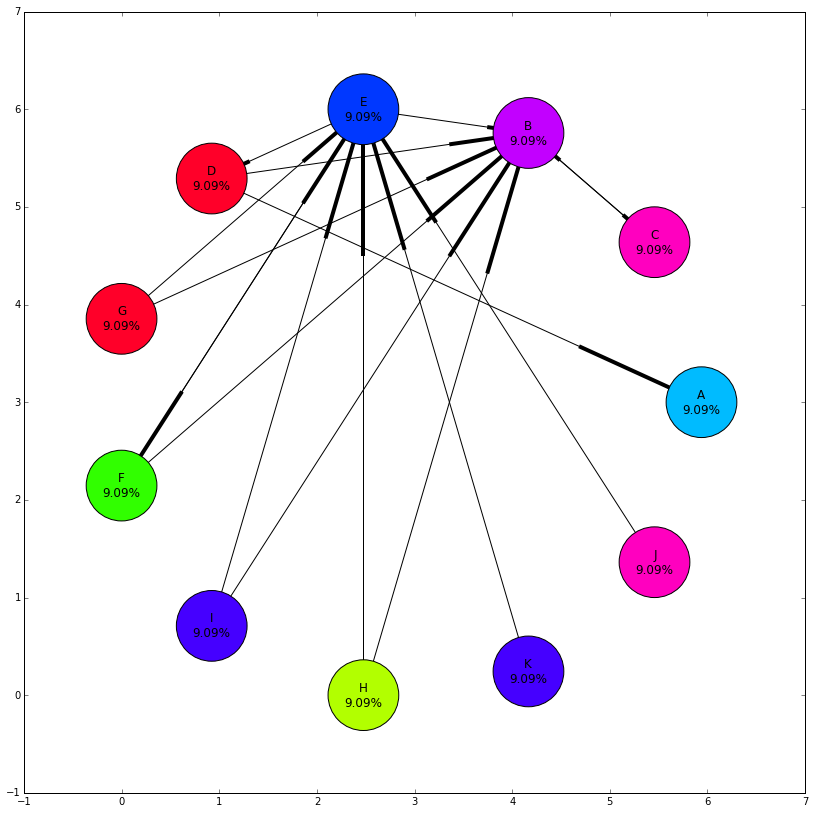

Damping Factor = 0.25


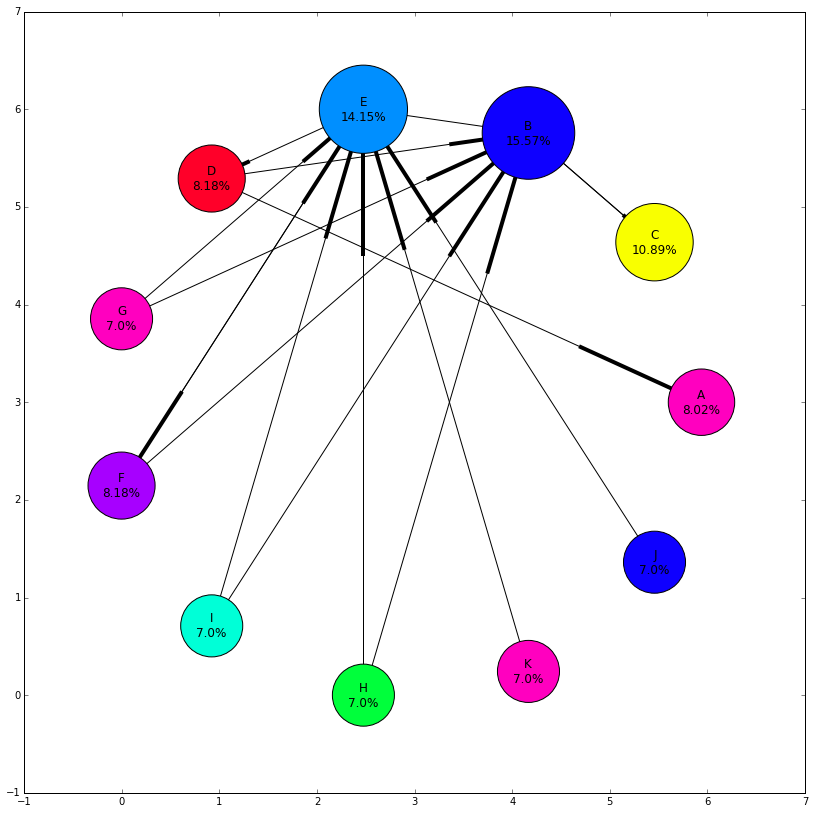

Damping Factor = 0.5


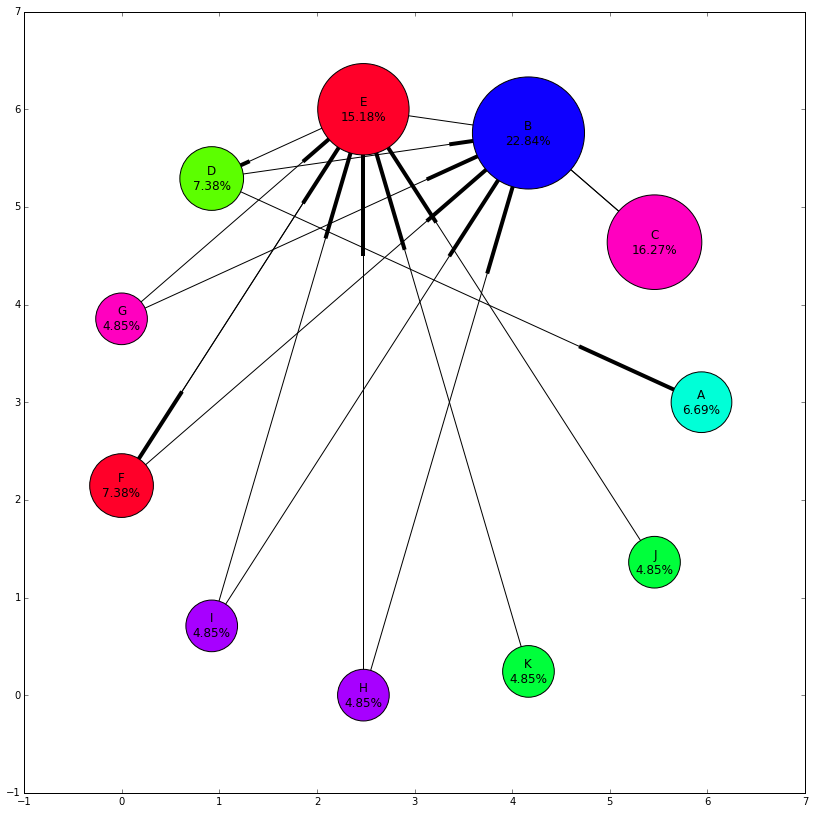

Damping Factor = 0.75


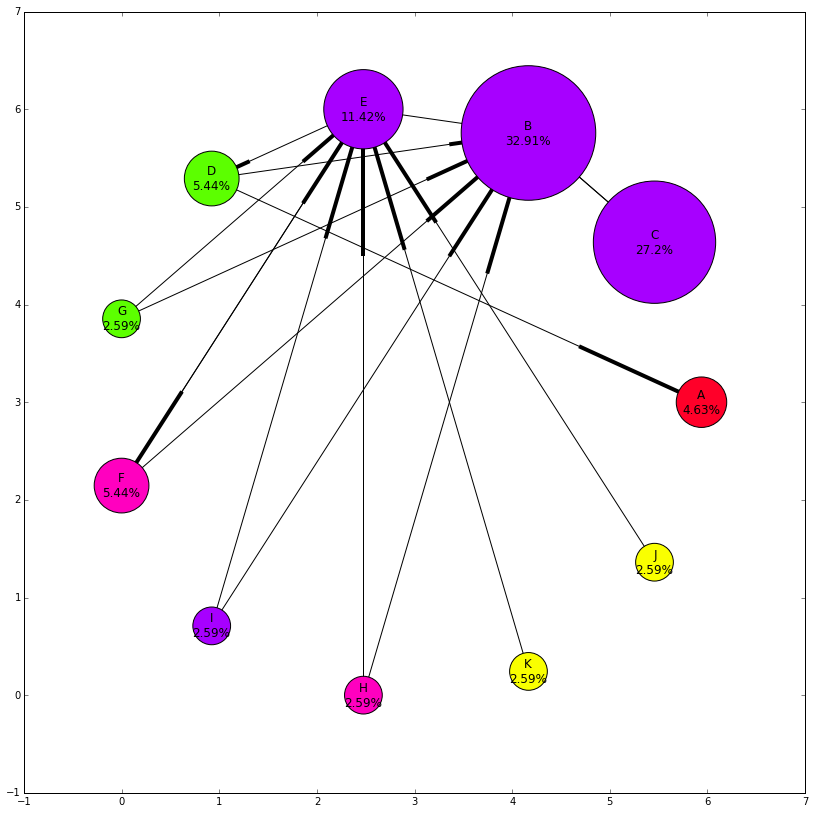

Damping Factor = 0.85


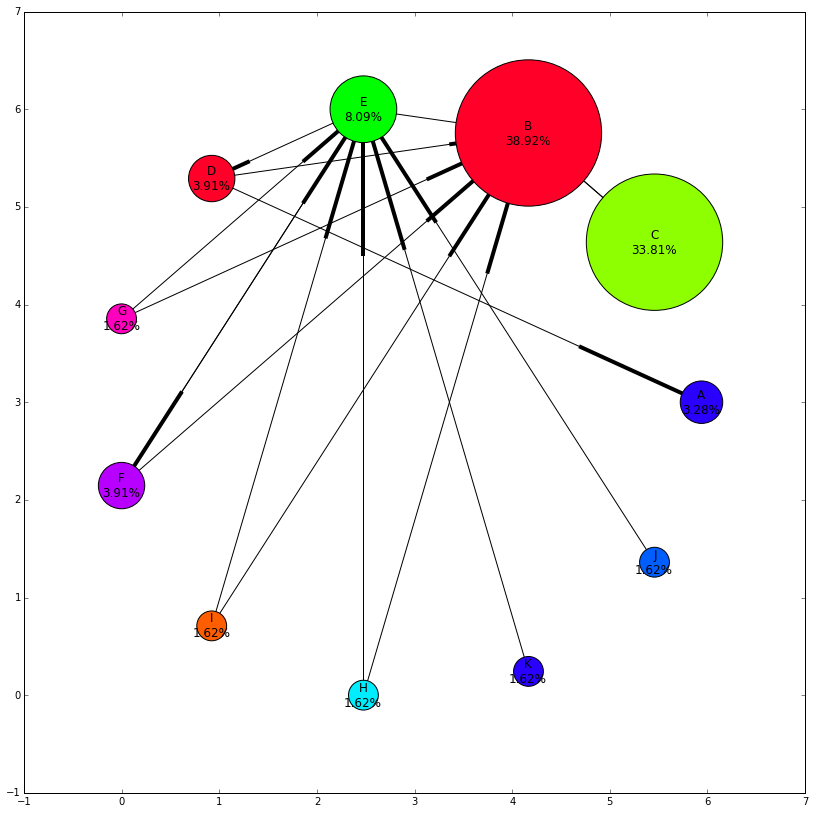

Damping Factor = 1


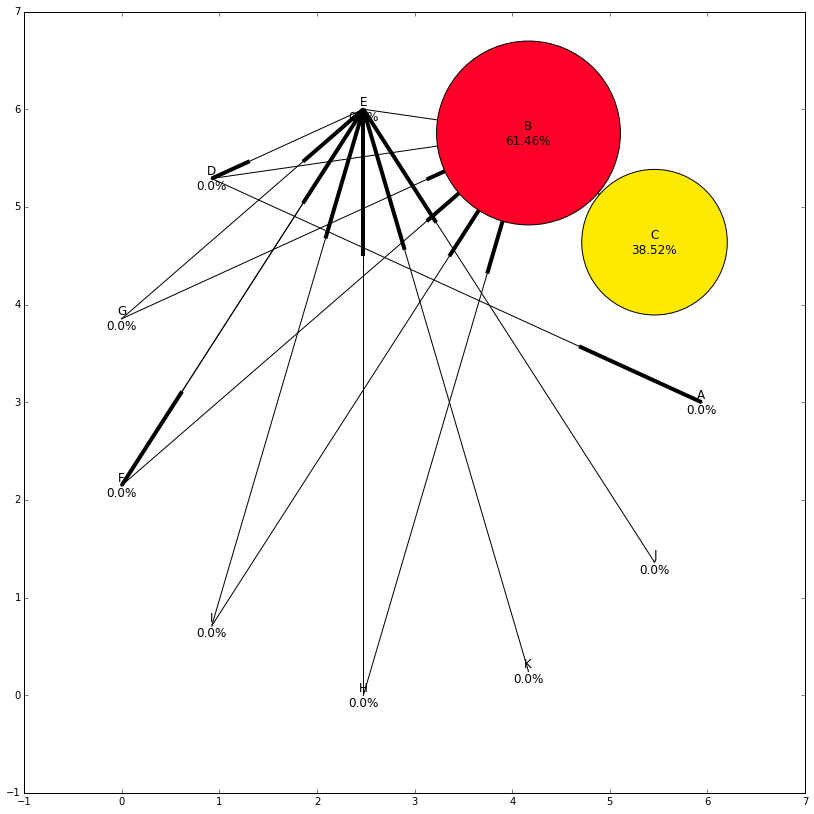

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import ast
import numpy as np

def create_graph(filename,df):
    node_size = {}
    node_color =[]
    labels = {}
    G=nx.DiGraph()
    with open(filename,"r") as fr:
        for f in fr:
            node_edge_list = f.split("\t")
            node     = node_edge_list[0]
            
            if(node_edge_list[1]!="NULL"):
                edge     = ast.literal_eval(node_edge_list[1])
            else:
                edge     = "NULL"
                
            pagerank = float(node_edge_list[2])
            
            if(edge=="NULL"):
                G.add_node(node)
                node_size[node]=pagerank*55000
                labels[node] =  node + "\n" + str(round(pagerank*100,2)) + "%"
                node_color.append(np.random.randint(12))
            else:
                G.add_node(node)
                node_size[node]=pagerank*55000
                labels[node] =  node + "\n" + str(round(pagerank*100,2)) + "%"
                node_color.append(np.random.randint(12))
                for k in edge.keys():
                    G.add_edge(node,k,weights=300)
    #pos = nx.spring_layout(G,k=0.5,iterations=20)
    plt.figure(figsize=(14,14))
    pos = nx.circular_layout(G,scale=6)
    
    ns=[]
    for n in G.nodes():
        ns.append(node_size[n])
    
    nx.draw_networkx(G,pos,node_size=ns,node_color=node_color,cmap=plt.cm.gist_rainbow,labels=labels)
    print "Damping Factor =",df
    plt.show()

damping_factor = [0,0.25,0.5,0.75, 0.85, 1]  

for df in damping_factor:
    create_graph(str("page_rank_"+str(df)+".txt"),df)

## ===============================================
## ===HW 9.3: Applying PageRank to the Wikipedia hyperlinks network===

*Run your PageRank implementation on the Wikipedia dataset for 5 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).

Run your PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with teleportation factor of 0.15). 
Have the top 100 ranked pages changed? Comment on your findings. Plot the pagerank values for the top 100 pages resulting from the 5 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.*

## ================================================================
## ===HW 9.4: Topic-specific PageRank implementation using MRJob===

*Modify your PageRank implementation to produce a topic specific PageRank implementation,
as described in:*

http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf

*Note in this article that there is a special caveat to ensure that the transition matrix is irreducible.
This caveat lies in footnote 3 on page 3:*

	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.

*and must be adhered to for convergence to be guaranteed.*

*Run topic specific PageRank on the following randomly generated network of 100 nodes:*

s3://ucb-mids-mls-networks/randNet.txt (also available on Dropbox)

*which are organized into ten topics, as described in the file:*

s3://ucb-mids-mls-networks/randNet_topics.txt  (also available on Dropbox)

*Since there are 10 topics, your result should be 11 PageRank vectors
(one for the vanilla PageRank implementation in 9.1, and one for each topic
with the topic specific implementation). Print out the top ten ranking nodes 
and their topics for each of the 11 versions, and comment on your result. 
Assume a teleportation factor of 0.15 in all your analyses.*

*One final and important comment here:  please consider the 
requirements for irreducibility with topic-specific PageRank.
In particular, the literature ensures irreducibility by requiring that
nodes not reachable from in-topic nodes be removed from the network.*

*This is not a small task, especially as it it must be performed
separately for each of the (10) topics.*

*So, instead of using this method for irreducibility, 
please comment on why the literature's method is difficult to implement,
and what what extra computation it will require.
Then for your code, please use the alternative, 
non-uniform damping vector:*

$v_{ji} = \beta*(\frac{1}{|T_j|})$; if node $i$ lies in topic $T_j$

$v_{ji} = (1-\beta)*(\frac{1}{(N - |T_j|)})$; if node $i$ lies outside of topic $T_j$

for $\beta \in (0,1)$ close to 1. 

*With this approach, you will not have to delete any nodes.*
*If $\beta > 0.5$, PageRank is topic-sensitive,* 
*and if $\beta < 0.5$, the PageRank is anti-topic-sensitive.*
*For any value of $\beta$ irreducibility should hold,
so please try $\beta=0.99$, and perhaps some other values locally,
on the smaller networks.*

## ===============================================
## ===HW 9.5: Applying topic-specific PageRank to Wikipedia (Optional)===

*Here you will apply your topic-specific PageRank implementation to Wikipedia,
defining topics (very arbitrarily) for each page by the length (number of characters) of the name of the article mod 10,
so that there are 10 topics. Once again, print out the top ten ranking nodes 
and their topics for each of the 11 versions, and comment on your result.
Assume a teleportation factor of 0.15 in all your analyses.*

## ==============================
## ===HW 9.6: TextRank (OPTIONAL)===

*What is TextRank. Describe the main steps in the algorithm. Why does TextRank work?*




**ANSWER**

*Implement TextRank in MrJob for keyword phrases (not just unigrams) extraction using co-occurrence based similarity measure with with sizes of N = 2 and 3. And evaluate your code using the following example using precision, recall, and FBeta (Beta=1):*

*"Compatibility of systems of linear constraints over the set of natural numbers
Criteria of compatibility of a system of linear Diophantine equations, strict 
inequations, and nonstrict inequations are considered. Upper bounds for
components of a minimal set of solutions and algorithms of construction of 
minimal generating sets of solutions for all types of systems are given. 
These criteria and the corresponding algorithms for constructing a minimal 
supporting set of solutions can be used in solving all the considered types of 
systems and systems of mixed types." *

*The extracted keywords should in the following set:*

*linear constraints, linear diophantine equations, natural numbers, non-strict inequations, strict inequations, upper bounds*